In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
# dataset_path = "drive/MyDrive/xBD/finalDataSetMaybe/"
dataset_path = "drive/MyDrive/xBD/finalNoMaybe/"
preImages_path = os.path.join(dataset_path, "preImages/")
postImages_path = os.path.join(dataset_path, "postImages/")
preMasks_path = os.path.join(dataset_path, "preMasks/")
postMasks_path = os.path.join(dataset_path, "postMasks/")

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, preimage_paths, premask_paths, postimage_paths, postmask_paths,transform=None):
        self.preimage_paths = preimage_paths
        self.premask_paths = premask_paths
        self.postimage_paths = postimage_paths
        self.postmask_paths = postmask_paths
        self.transform = transform

    def __len__(self):
        return len(self.preimage_paths)

    def __getitem__(self, idx):
        preimage_paths = self.preimage_paths[idx]
        premask_paths = self.premask_paths[idx]
        preImg = Image.open(preimage_paths).convert("RGB")
        preMask = Image.open(premask_paths).convert("L")  # Convert to grayscale mask

        postimage_paths = self.postimage_paths[idx]
        postmask_paths = self.postmask_paths[idx]
        postImg = Image.open(postimage_paths).convert("RGB")
        postMask = Image.open(postmask_paths).convert("L")  # Convert to grayscale mask

        if self.transform:
            preImg = self.transform(preImg)
            preMask = self.transform(preMask)
            postImg = self.transform(postImg)
            postMask = self.transform(postMask)
        return preImg,preMask,postImg,postMask  # Add batch dimension to mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load datasets
all_dataset = CustomDataset(preimage_paths=glob.glob(preImages_path + "*.png"),
                                  premask_paths=glob.glob(preMasks_path + "*.png"),
                                  postimage_paths = glob.glob(postImages_path + "*.png"),
                                  postmask_paths = glob.glob(postMasks_path + "*.png"),
                                  transform=transform)
# postImages_dataset = CustomDataset(image_paths=glob.glob(postImages_path + "*.png"),
#                                    mask_paths=glob.glob(postMasks_path + "*.png"),
#                                    transform=transform)

# Create data loaders
batch_size = 1
data_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False)
# postImages_loader = DataLoader(postImages_dataset, batch_size=batch_size, shuffle=False)
# data_loader = DataLoader()

In [ ]:
# Display image and label.
pre_features, pre_labels, post_features, post_labels,  = next(iter(data_loader))
print(f"Feature batch shape: {pre_features.size()}")
print(f"Labels batch shape: {pre_labels.size()}")
print(f"Feature batch shape: {post_features.size()}")
print(f"Labels batch shape: {post_labels.size()}")
# img = train_features[0].squeeze()

Feature batch shape: torch.Size([1, 3, 256, 256])
Labels batch shape: torch.Size([1, 1, 256, 256])
Feature batch shape: torch.Size([1, 3, 256, 256])
Labels batch shape: torch.Size([1, 1, 256, 256])


In [ ]:
data_loader.__len__()

3744

In [ ]:
class SiamUnet(nn.Module):

    def __init__(self, in_channels=3, out_channels_s=2, out_channels_c=5, init_features=16):
        super(SiamUnet, self).__init__()

        features = init_features

        # UNet layers
        self.encoder1 = SiamUnet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = SiamUnet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = SiamUnet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = SiamUnet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = SiamUnet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = SiamUnet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = SiamUnet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = SiamUnet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = SiamUnet._block(features * 2, features, name="dec1")

        self.conv_s = nn.Conv2d(in_channels=features, out_channels=out_channels_s, kernel_size=1)

        # Siamese classifier layers
        self.upconv4_c = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.conv4_c = SiamUnet._block(features * 16, features * 16, name="conv4")

        self.upconv3_c = nn.ConvTranspose2d(features * 16, features * 4, kernel_size=2, stride=2)
        self.conv3_c = SiamUnet._block(features * 8, features * 8, name="conv3")

        self.upconv2_c = nn.ConvTranspose2d(features * 8, features * 2, kernel_size=2, stride=2)
        self.conv2_c = SiamUnet._block(features * 4, features * 4, name="conv2")

        self.upconv1_c = nn.ConvTranspose2d(features * 4, features, kernel_size=2, stride=2)
        self.conv1_c = SiamUnet._block(features * 2, features * 2, name="conv1")

        self.conv_c = nn.Conv2d(in_channels=features * 2, out_channels=out_channels_c, kernel_size=1)


    def forward(self, x1, x2):

        # UNet on x1
        enc1_1 = self.encoder1(x1)
        enc2_1 = self.encoder2(self.pool1(enc1_1))
        enc3_1 = self.encoder3(self.pool2(enc2_1))
        enc4_1 = self.encoder4(self.pool3(enc3_1))

        bottleneck_1 = self.bottleneck(self.pool4(enc4_1))

        dec4_1 = self.upconv4(bottleneck_1)
        dec4_1 = torch.cat((dec4_1, enc4_1), dim=1)
        dec4_1 = self.decoder4(dec4_1)
        dec3_1 = self.upconv3(dec4_1)
        dec3_1 = torch.cat((dec3_1, enc3_1), dim=1)
        dec3_1 = self.decoder3(dec3_1)
        dec2_1 = self.upconv2(dec3_1)
        dec2_1 = torch.cat((dec2_1, enc2_1), dim=1)
        dec2_1 = self.decoder2(dec2_1)
        dec1_1 = self.upconv1(dec2_1)
        dec1_1 = torch.cat((dec1_1, enc1_1), dim=1)
        dec1_1 = self.decoder1(dec1_1)

        # UNet on x2
        enc1_2 = self.encoder1(x2)
        enc2_2 = self.encoder2(self.pool1(enc1_2))
        enc3_2 = self.encoder3(self.pool2(enc2_2))
        enc4_2 = self.encoder4(self.pool3(enc3_2))

        bottleneck_2 = self.bottleneck(self.pool4(enc4_2))

        dec4_2 = self.upconv4(bottleneck_2)
        dec4_2 = torch.cat((dec4_2, enc4_2), dim=1)
        dec4_2 = self.decoder4(dec4_2)
        dec3_2 = self.upconv3(dec4_2)
        dec3_2 = torch.cat((dec3_2, enc3_2), dim=1)
        dec3_2 = self.decoder3(dec3_2)
        dec2_2 = self.upconv2(dec3_2)
        dec2_2 = torch.cat((dec2_2, enc2_2), dim=1)
        dec2_2 = self.decoder2(dec2_2)
        dec1_2 = self.upconv1(dec2_2)
        dec1_2 = torch.cat((dec1_2, enc1_2), dim=1)
        dec1_2 = self.decoder1(dec1_2)

        # Siamese
        dec1_c = bottleneck_2 - bottleneck_1

        dec1_c = self.upconv4_c(dec1_c) # features * 16 -> features * 8
        diff_2 = enc4_2 - enc4_1 # features * 16 -> features * 8
        dec2_c = torch.cat((diff_2, dec1_c), dim=1) #512
        dec2_c = self.conv4_c(dec2_c)

        dec2_c = self.upconv3_c(dec2_c) # 512->256
        diff_3 = enc3_2 - enc3_1
        dec3_c = torch.cat((diff_3, dec2_c), dim=1) # ->512
        dec3_c = self.conv3_c(dec3_c)

        dec3_c = self.upconv2_c(dec3_c) #512->256
        diff_4 = enc2_2 - enc2_1
        dec4_c = torch.cat((diff_4, dec3_c), dim=1) #
        dec4_c = self.conv2_c(dec4_c)

        dec4_c = self.upconv1_c(dec4_c)
        diff_5 = enc1_2 - enc1_1
        dec5_c = torch.cat((diff_5, dec4_c), dim=1)
        dec5_c = self.conv1_c(dec5_c)

        return self.conv_s(dec1_1), self.conv_s(dec1_2), self.conv_c(dec5_c)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
from collections import OrderedDict

In [ ]:
import time

In [ ]:

# Instantiate the UNet model
model = SiamUnet()

# Define loss function (example using Binary Cross Entropy)
binaryCriterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    step = 0
    print(f"\nStart of epoch {epoch}")
    start_time = time.time()
    for pre_img, pre_mask, post_img, post_mask in data_loader:
        step +=1
        preImg, preMask, postImg, postMask = pre_img, pre_mask, post_img, post_mask  # Assuming data is already on correct device

        optimizer.zero_grad()
        outputs = model(pre_img,post_img)
        # Calculate loss

        preMask = torch.argmax(preMask, dim=1)
        postMask = torch.argmax(postMask, dim=1)
        loss1 = criterion(outputs[0], preMask)
        loss2 = criterion(outputs[1], preMask)

        loss3 = criterion(outputs[2],postMask)
        # softmax = torch.nn.Softmax(dim=1)
        # preds_seg_pre = torch.argmax(softmax(outputs[0]), dim=1)
        # preds_seg_post = torch.argmax(softmax(outputs[1]), dim=1)
        # preds_seg_class = torch.argmax(softmax(outputs[2]), dim=1)
        # print(torch.unique(preds_seg_pre))
        # print(torch.unique(preds_seg_post))
        # print(torch.unique(preds_seg_class))
        loss = loss1 + loss2 +loss3
        # print(outputs[1].size())

        # print(outputs[2].size())
        # print(loss1)
        # print(loss2)

        # Backward and optimize

        # loss1.backward()
        # loss2.backward()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(
                f"Training loss (for 1 batch) at step {step}: , Loss1: {loss1}, Loss2: {loss2}, Loss3: {loss3}, "
            )
            print(f"Time taken: {time.time() - start_time:.2f}s")

# # Save the model
# torch.save(model.state_dict(), 'unet_model.pth')



Start of epoch 0
Training loss (for 1 batch) at step 100: , Loss1: 0.1533835530281067, Loss2: 0.15442518889904022, Loss3: 0.14873281121253967, 
Time taken: 298.46s
Training loss (for 1 batch) at step 200: , Loss1: 0.05962301790714264, Loss2: 0.05940503999590874, Loss3: 0.03762487322092056, 
Time taken: 586.91s
Training loss (for 1 batch) at step 300: , Loss1: 0.028664488345384598, Loss2: 0.02908509224653244, Loss3: 0.016983408480882645, 
Time taken: 878.27s
Training loss (for 1 batch) at step 400: , Loss1: 0.017902173101902008, Loss2: 0.01721157319843769, Loss3: 0.009765200316905975, 
Time taken: 1181.62s
Training loss (for 1 batch) at step 500: , Loss1: 0.011318575590848923, Loss2: 0.011312898248434067, Loss3: 0.006365922745317221, 
Time taken: 1472.74s
Training loss (for 1 batch) at step 600: , Loss1: 0.007806052919477224, Loss2: 0.007913816720247269, Loss3: 0.0043811737559735775, 
Time taken: 1770.12s
Training loss (for 1 batch) at step 700: , Loss1: 0.005886097904294729, Loss2: 0.

In [ ]:
PATH = "drive/MyDrive/xBD/siamUnet.pt"

In [ ]:
torch.save(model, PATH)

In [ ]:
print(f"Time taken: {time.time() - start_time:.2f}s")

Time taken: 10682.38s


In [ ]:
model = torch.load(PATH)

In [ ]:
# Testing Prep

# data path
dataset_path = "drive/MyDrive/xBD/testDataSet/"
preImages_path = os.path.join(dataset_path, "preImg/")
postImages_path = os.path.join(dataset_path, "postImg/")
preMasks_path = os.path.join(dataset_path, "preMask/")
postMasks_path = os.path.join(dataset_path, "postMask/")

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, preimage_paths, premask_paths, postimage_paths, postmask_paths,transform=None):
        self.preimage_paths = preimage_paths
        self.premask_paths = premask_paths
        self.postimage_paths = postimage_paths
        self.postmask_paths = postmask_paths
        self.transform = transform

    def __len__(self):
        return len(self.preimage_paths)

    def __getitem__(self, idx):
        preimage_paths = self.preimage_paths[idx]
        premask_paths = self.premask_paths[idx]
        preImg = Image.open(preimage_paths).convert("RGB")
        preMask = Image.open(premask_paths).convert("L")  # Convert to grayscale mask

        postimage_paths = self.postimage_paths[idx]
        postmask_paths = self.postmask_paths[idx]
        postImg = Image.open(postimage_paths).convert("RGB")
        postMask = Image.open(postmask_paths).convert("L")  # Convert to grayscale mask

        if self.transform:
            preImg = self.transform(preImg)
            preMask = self.transform(preMask)
            postImg = self.transform(postImg)
            postMask = self.transform(postMask)
        return preImg,preMask,postImg,postMask  # Add batch dimension to mask

# Define transformations
transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.PILToTensor()
])


# Load datasets
test_dataset = CustomDataset(preimage_paths=glob.glob(preImages_path + "*.png"),
                                  premask_paths=glob.glob(preMasks_path + "*.png"),
                                  postimage_paths = glob.glob(postImages_path + "*.png"),
                                  postmask_paths = glob.glob(postMasks_path + "*.png"),
                                  transform=transform)
# postImages_dataset = CustomDataset(image_paths=glob.glob(postImages_path + "*.png"),
#                                    mask_paths=glob.glob(postMasks_path + "*.png"),
#                                    transform=transform)

# Create data loaders
batch_size = 1
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Display image and label.
pre_features, pre_labels, post_features, post_labels,  = next(iter(test_data_loader))
print(f"Feature batch shape: {pre_features.size()}")
print(f"Labels batch shape: {pre_labels.size()}")
print(f"Feature batch shape: {post_features.size()}")
print(f"Labels batch shape: {post_labels.size()}")
# img = train_features[0].squeeze()
test_data_loader.__len__()

Feature batch shape: torch.Size([1, 3, 256, 256])
Labels batch shape: torch.Size([1, 1, 256, 256])
Feature batch shape: torch.Size([1, 3, 256, 256])
Labels batch shape: torch.Size([1, 1, 256, 256])


1

In [ ]:
torch.unique(post_labels)

tensor([0.0000, 0.0039, 0.0078])

In [ ]:
for test_pre_img, test_pre_mask, test_post_img, test_post_mask in test_data_loader:
        test_pre_img, test_pre_mask, test_post_img, test_post_mask = test_pre_img, test_pre_mask, test_post_img, test_post_mask  # Assuming data is already on correct device
        outputs = model(test_pre_img,test_post_img)



In [ ]:
outputs

(tensor([[[[ 4.4697,  4.3400,  4.3055,  ...,  4.2944,  4.3195,  4.3872],
           [ 4.4335,  4.3207,  4.3364,  ...,  4.3552,  4.3044,  4.3692],
           [ 4.4199,  4.3660,  4.3850,  ...,  4.3841,  4.3587,  4.3872],
           ...,
           [ 4.4422,  4.3515,  4.3712,  ...,  4.3507,  4.3491,  4.3440],
           [ 4.5133,  4.4658,  4.4168,  ...,  4.4062,  4.3792,  4.3951],
           [ 4.5261,  4.5500,  4.5714,  ...,  4.5304,  4.5175,  4.5222]],
 
          [[-5.3592, -5.3592, -5.4610,  ..., -5.4280, -5.5108, -5.5264],
           [-5.2922, -5.3014, -5.3538,  ..., -5.2916, -5.3493, -5.3491],
           [-5.2881, -5.2910, -5.3223,  ..., -5.2766, -5.2919, -5.3152],
           ...,
           [-5.3036, -5.2812, -5.3439,  ..., -5.2968, -5.3300, -5.2992],
           [-5.3420, -5.2866, -5.2601,  ..., -5.2686, -5.2834, -5.2876],
           [-5.3242, -5.2070, -5.1540,  ..., -5.1921, -5.1875, -5.2472]]]],
        grad_fn=<ConvolutionBackward0>),
 tensor([[[[ 4.4853,  4.3497,  4.3169,  ..., 

In [ ]:
# compute predictions & confusion metrics
softmax = torch.nn.Softmax(dim=1)
preds_seg_pre = torch.argmax(softmax(outputs[0]), dim=1)
preds_seg_post = torch.argmax(softmax(outputs[1]), dim=1)
preds_cls = torch.argmax(softmax(outputs[2]), dim=1)

In [ ]:
torch.unique(preds_cls)

tensor([0])

In [ ]:
preds_cls

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [ ]:
# Visualizing Output

import matplotlib.pyplot as plt

f, ax = plt.subplots(1,2, figsize=(30,9))
test = torch.argmax(test_pre_mask, dim=1)
ax[0].imshow(test.permute(1, 2, 0))
ax[0].axis('off')
output = torch.argmax(outputs[0], dim=1)
ax[1].imshow(output.permute(1, 2, 0))
ax[1].axis('off')
f.tight_layout()
f.show()

In [ ]:
# Visualizing Mask Output - Colour Coded

!git clone https://github.com/microsoft/ai4eutils

!export PYTHONPATH="${PYTHONPATH}:/ai4eutils"

Cloning into 'ai4eutils'...
remote: Enumerating objects: 787, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 787 (delta 54), reused 52 (delta 37), pack-reused 694
Receiving objects: 100% (787/787), 2.59 MiB | 12.38 MiB/s, done.
Resolving deltas: 100% (469/469), done.


In [ ]:
import os
os.kill(os.getpid(), 9)

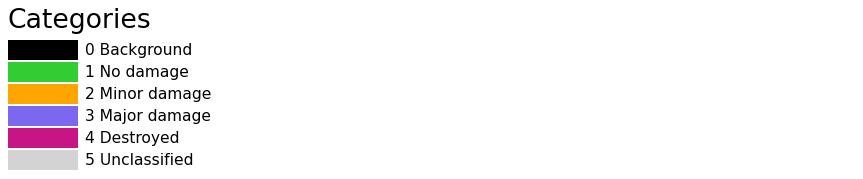

In [ ]:
import sys
sys.path.append('ai4eutils')
from geospatial.visualization.raster_label_visualizer import RasterLabelVisualizer
viz = RasterLabelVisualizer(label_map='/content/drive/MyDrive/xBD/xBD_label_map.json')
l = viz.plot_color_legend()

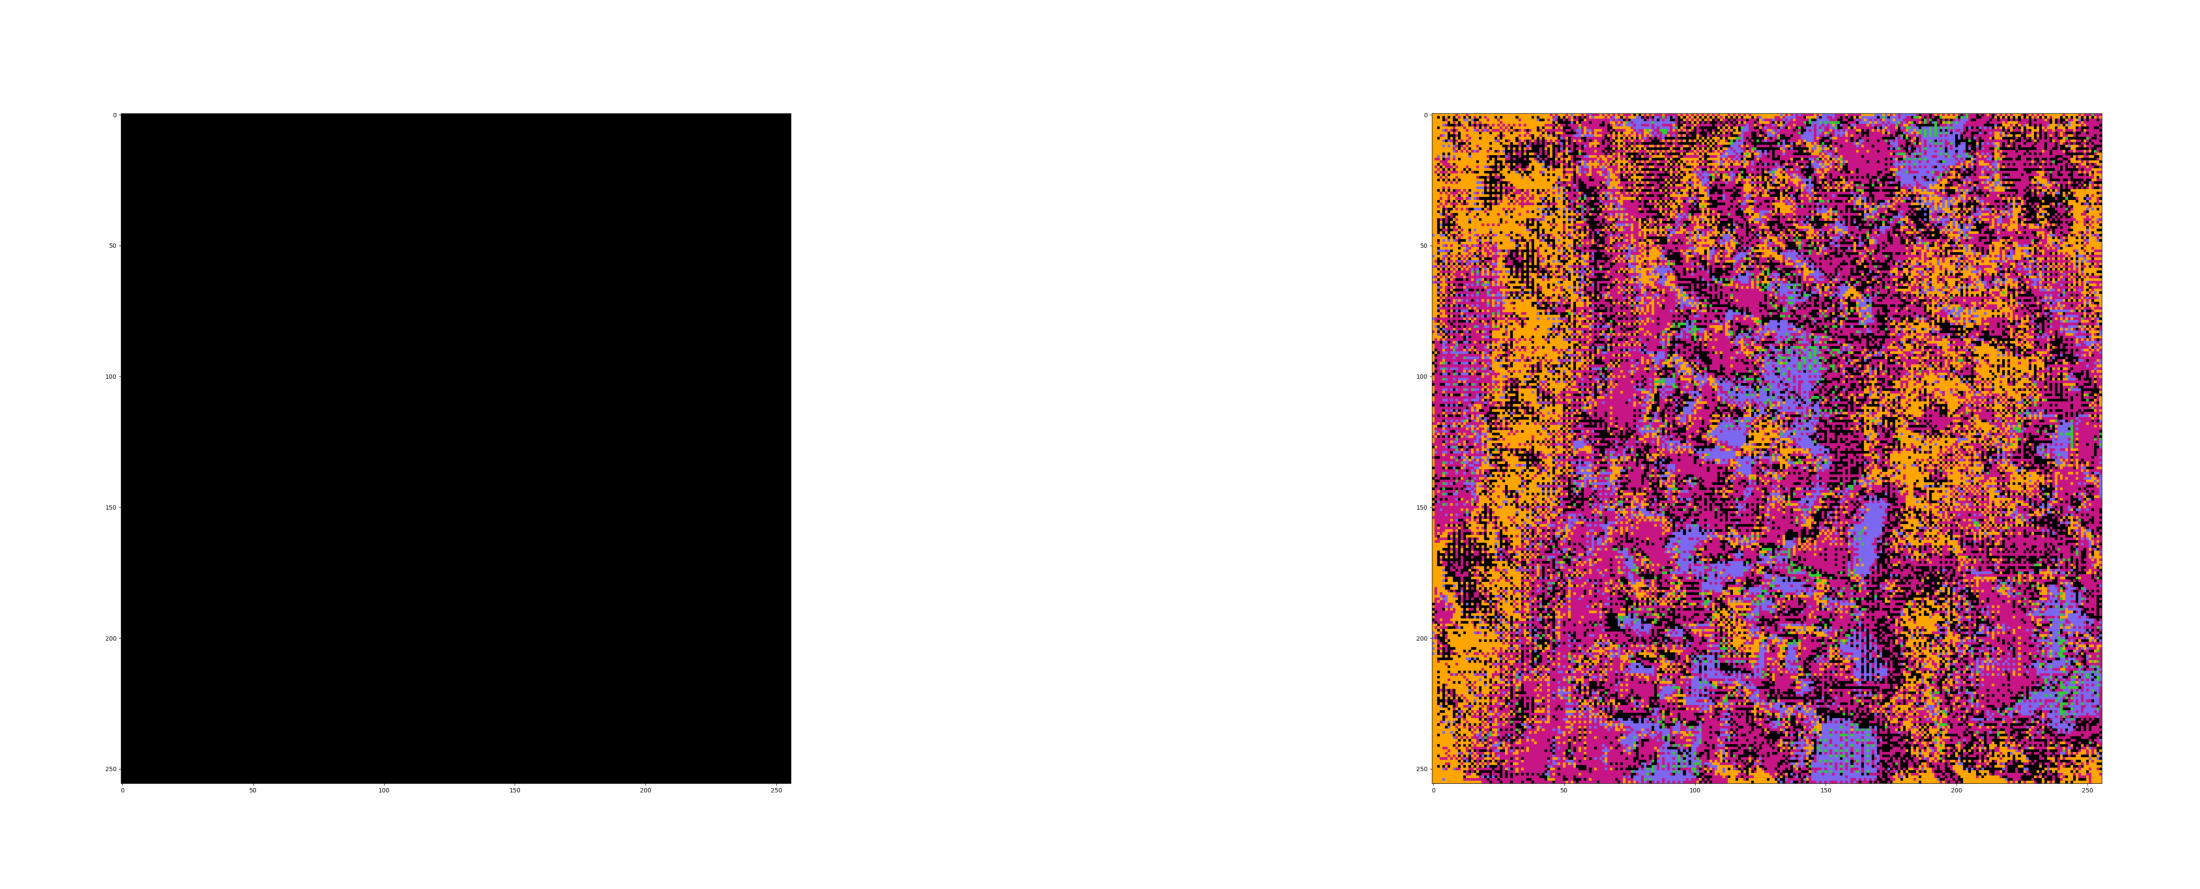

In [ ]:
import matplotlib.pyplot as plt

ground_truth_pre_mask = torch.argmax(test_post_mask, dim=1)
ground_truth_pre_mask = ground_truth_pre_mask.permute(1,2,0)
ground_truth_pre_mask, buf = viz.show_label_raster(ground_truth_pre_mask, size=(20, 20))
f, ax = plt.subplots(1,2, figsize=(30,9))


output_pre = preds_cls
# output_pre = torch.argmax(outputs[2], dim=1)
output_pre = output_pre.permute(1,2,0)
output_pre, buf = viz.show_label_raster(output_pre, size=(20, 20))


ax[0].imshow(ground_truth_pre_mask)
ax[0].axis('off')
ax[1].imshow(output_pre)
ax[1].axis('off')
f.tight_layout()
f.show()

In [ ]:
torch.unique(preds_cls)

tensor([0, 1, 2, 3, 4])

In [ ]:
from torchvision.utils import save_image

SAVE_PATH = "/content/drive/MyDrive/xBD/testOutputs/mexico-earthquake_00000039_-1"

# pre_output_save = torch.argmax(outputs[0], dim=1)
# pre_output_save = pre_output_save.permute(1,2,0)
# pre_output_save = pre_output_save.detach().numpy().astype(np.uint8)
# im = Image.fromarray(pre_output_save)
# im.save(SAVE_PATH + "-pre_output.png")

save_image(preds_seg_pre, SAVE_PATH  + "-pre_output.png")

save_image(preds_seg_post, SAVE_PATH  + "-post_output.png")

save_image(preds_cls, SAVE_PATH + "-damage_output.png")


# post_output_save = torch.argmax(outputs[1], dim=1)
# post_output_save = post_output_save.permute(1,2,0)
# im = Image.fromarray(post_output_save)
# im.save(SAVE_PATH + "-post_output.png")

# damage_output_save = torch.argmax(outputs[2], dim=1)
# damage_output_save = damage_output_save.permute(1,2,0)
# im = Image.fromarray(damage_output_save)
# im.save(SAVE_PATH + "-damage_output.png")

In [ ]:
outputs[2]

In [ ]:
# save output

torch.save(outputs, "/content/drive/MyDrive/xBD/testOutputs/testOutputs.pt")